<h2 style="color:blue" align="center">Plain Deep Neural Network (DNN) on CIFAR</h2>

#### Import the necessary libraries

In [20]:
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random as python_random
import time, math 

from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D 
from keras.callbacks import Callback, CSVLogger

import warnings
warnings.filterwarnings('ignore')

#### Reserve GPU memory for the execution

In [21]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


#### Load and split the dataset into training and testing set

CIFAR 10

In [22]:
#(X_train,y_train),(X_test,y_test) = keras.datasets.cifar10.load_data()

CIFAR 100

In [23]:
(X_train,y_train),(X_test,y_test) = keras.datasets.cifar100.load_data()

169001437/169001437 [==============================] - 44s 0us/step


Here we see there are 50000 training images and 1000 test images

#### Normalize the input dataset

In [24]:
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

In [25]:
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

#### Define DNN model

In [26]:
python_random.seed(7)
np.random.seed(7)
tf.random.set_seed(7)
opti_name = ''

def get_model(): 
    model = Sequential([ 
          Flatten(input_shape=(32,32,3)),
          Dense(3000, activation = 'relu'),
          Dense(1000, activation = 'relu'),
          # For CIFAR-10
          #Dense(10, activation = 'softmax')
          # For CIFAR-100
          Dense(100, activation = 'softmax')
    ]) 
    
    global opti_name
    
    # General SGD
    #opti = keras.optimizers.SGD(learning_rate=0.001)
    #opti_name = 'SGD'
    
    # SGD with momentum
    #opti = keras.optimizers.SGD(learning_rate=0.001, momentum=0.4)
    #opti_name = 'SGD with momentum'
    
    # SGD with Nesterov momentum 
    #opti = keras.optimizers.SGD(learning_rate=0.001, momentum=0.4, nesterov=True)
    #opti_name = 'SGD with Nesterov momentum'
    
    # RMSprop 
    #opti = keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.4)
    #opti_name = 'RMSprop'
    
    # Adam
    opti = keras.optimizers.Adam(learning_rate=0.001) 
    opti_name = 'Adam'
    
    # Adamax
    #opti = keras.optimizers.Adamax(learning_rate=0.001) 
    #opti_name = 'Adamax'
    
    model.compile(
        optimizer = opti,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    return model

#### Custom callbacks

For generic optimizer model

In [27]:
# Get the best of base-line model and set it as stopping criteria in HM-based model
generic_best = 0

class CustomCallbackGeneric(Callback):  
    def on_epoch_end(self, epoch, logs={}): 
        global generic_best
        accuracy = round(logs.get('accuracy'), 4) 
        
        if epoch == 0:
            generic_best = accuracy     
        
        if epoch > 0 and accuracy < generic_best :
            generic_best = accuracy

For HM based optimizer model

In [28]:
class CustomCallbackHM(Callback):  
    initial_weights = 0
    previous_weights = 0
    call_hm = 0    
     
    def on_train_begin(self, logs=None):
        self.initial_weights = model_hm.get_weights() 
        self.initial_weights = np.array(self.initial_weights,dtype=object)
        self.previous_weights = self.initial_weights
        # Harmonic mean based weights calculation
        self.call_hm = np.vectorize(self.apply_hm)  

    def on_epoch_end(self, epoch, logs={}): 
         # Set the stopping criteria at (stop_at) the MAE obtained from the baseline model 
        global generic_best 
        
        num_layers = len(model_hm.layers)  
        current_weights = model_hm.get_weights()
        current_weights = np.array(current_weights,dtype=object)        

        for i in range(num_layers-1):  
            # Harmonic mean based weights calculation
            tensor1 = tf.convert_to_tensor(self.previous_weights[i])
            tensor2 = tf.convert_to_tensor(current_weights[i])
            current_weights[i] = self.call_hm(tensor1, tensor2, epoch)   
            
        # Updating the model with new weights
        model_hm.set_weights(current_weights.tolist())
        self.previous_weights = current_weights 
        
        #Stopping criteria
        #if(round(logs.get('accuracy'), 4) < generic_best):  
            #self.model.stop_training = True
        
    def apply_hm(self, v1, v2, epoch):   
        r = 0
        if epoch < 50:
            r = 1
        elif epoch > 50 and epoch < 100:
            r = 0.75
        elif epoch > 100 and epoch < 150:
            r = 0.5
        else:  
            r = 0.25 
            
        if v1==0 or v2==0:
            return v2
        elif v1 > v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1) * r 
            v2 = v2 - diff
            return v2  
        elif v1 < v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1) * r 
            v2 = v2 + diff
            return v2   
        else:
            return v2   

#### Training

Get a model to assign same weights to model with and without HM

In [29]:
model = get_model() 
weights = model.get_weights() 
num_epochs = 100
batch_size = 256

To record loss and accuracy in CSV file

In [30]:
generic_file = '3.CIFAR '+ opti_name +' optimizer.csv'
hm_file = '3.CIFAR '+ opti_name +' HM-based optimizer.csv' 
logger_generic_model = CSVLogger(generic_file, append = False, separator=',')
logger_hm_model = CSVLogger(hm_file, append = False, separator=',')

Generic opimizer model

In [31]:
model_wihtout_hm = get_model()
model_wihtout_hm.set_weights(weights) 
st = time.time() 
model_wihtout_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=1, callbacks=[CustomCallbackGeneric(), logger_generic_model], batch_size=batch_size) 
et = time.time()
elapsed_training_time_generic = round(et - st, 4)
print('Execution time:', elapsed_training_time_generic, 'seconds') 

Epoch 1/100
196/196 [==============================] - 1s 4ms/step - loss: 4.3219 - accuracy: 0.0589
Epoch 2/100
196/196 [==============================] - 1s 3ms/step - loss: 3.7539 - accuracy: 0.1255
Epoch 3/100
196/196 [==============================] - 1s 3ms/step - loss: 3.5569 - accuracy: 0.1614
Epoch 4/100
196/196 [==============================] - 1s 3ms/step - loss: 3.4374 - accuracy: 0.1840
Epoch 5/100
196/196 [==============================] - 1s 3ms/step - loss: 3.3408 - accuracy: 0.2015
Epoch 6/100
196/196 [==============================] - 1s 3ms/step - loss: 3.2471 - accuracy: 0.2183
Epoch 7/100
196/196 [==============================] - 1s 3ms/step - loss: 3.1643 - accuracy: 0.2351
Epoch 8/100
196/196 [==============================] - 1s 3ms/step - loss: 3.1052 - accuracy: 0.2446
Epoch 9/100
196/196 [==============================] - 1s 3ms/step - loss: 3.0403 - accuracy: 0.2545
Epoch 10/100
196/196 [==============================] - 1s 3ms/step - loss: 2.9873 - accura

196/196 [==============================] - 0s 2ms/step - loss: 0.6316 - accuracy: 0.8142
Epoch 82/100
196/196 [==============================] - 0s 2ms/step - loss: 0.6325 - accuracy: 0.8126
Epoch 83/100
196/196 [==============================] - 0s 2ms/step - loss: 0.6205 - accuracy: 0.8167
Epoch 84/100
196/196 [==============================] - 0s 2ms/step - loss: 0.5733 - accuracy: 0.8337
Epoch 85/100
196/196 [==============================] - 0s 2ms/step - loss: 0.5707 - accuracy: 0.8315
Epoch 86/100
196/196 [==============================] - 0s 2ms/step - loss: 0.5713 - accuracy: 0.8293
Epoch 87/100
196/196 [==============================] - 0s 3ms/step - loss: 0.5509 - accuracy: 0.8368
Epoch 88/100
196/196 [==============================] - 0s 2ms/step - loss: 0.5422 - accuracy: 0.8398
Epoch 89/100
196/196 [==============================] - 0s 2ms/step - loss: 0.5229 - accuracy: 0.8447
Epoch 90/100
196/196 [==============================] - 1s 3ms/step - loss: 0.5224 - accuracy: 

HM based optimizer model

In [32]:
model_hm = get_model()
model_hm.set_weights(weights) 
st = time.time()
model_hm.fit(X_train_normalized, y_train, epochs = num_epochs, verbose=1, callbacks=[CustomCallbackHM(),logger_hm_model], batch_size=batch_size) 
et = time.time()
elapsed_training_time_hm = round(et - st, 4)
print('Execution time:', elapsed_training_time_hm, 'seconds')

Epoch 1/100
196/196 [==============================] - 5s 21ms/step - loss: 4.3223 - accuracy: 0.0583
Epoch 2/100
196/196 [==============================] - 4s 21ms/step - loss: 3.7476 - accuracy: 0.1281
Epoch 3/100
196/196 [==============================] - 4s 21ms/step - loss: 3.5485 - accuracy: 0.1632
Epoch 4/100
196/196 [==============================] - 4s 21ms/step - loss: 3.4074 - accuracy: 0.1906
Epoch 5/100
196/196 [==============================] - 4s 21ms/step - loss: 3.3093 - accuracy: 0.2067
Epoch 6/100
196/196 [==============================] - 4s 21ms/step - loss: 3.2079 - accuracy: 0.2255
Epoch 7/100
196/196 [==============================] - 4s 21ms/step - loss: 3.1190 - accuracy: 0.2428
Epoch 8/100
196/196 [==============================] - 4s 21ms/step - loss: 3.0560 - accuracy: 0.2532
Epoch 9/100
196/196 [==============================] - 4s 21ms/step - loss: 2.9796 - accuracy: 0.2649
Epoch 10/100
196/196 [==============================] - 5s 23ms/step - loss: 2.916

196/196 [==============================] - 3s 14ms/step - loss: 0.5229 - accuracy: 0.8450
Epoch 81/100
196/196 [==============================] - 3s 13ms/step - loss: 0.5265 - accuracy: 0.8420
Epoch 82/100
196/196 [==============================] - 3s 13ms/step - loss: 0.5456 - accuracy: 0.8378
Epoch 83/100
196/196 [==============================] - 2s 13ms/step - loss: 0.5327 - accuracy: 0.8403
Epoch 84/100
196/196 [==============================] - 3s 13ms/step - loss: 0.5040 - accuracy: 0.8473
Epoch 85/100
196/196 [==============================] - 3s 13ms/step - loss: 0.4951 - accuracy: 0.8505
Epoch 86/100
196/196 [==============================] - 3s 14ms/step - loss: 0.5011 - accuracy: 0.8475
Epoch 87/100
196/196 [==============================] - 3s 13ms/step - loss: 0.4875 - accuracy: 0.8536
Epoch 88/100
196/196 [==============================] - 3s 13ms/step - loss: 0.4913 - accuracy: 0.8512
Epoch 89/100
196/196 [==============================] - 3s 13ms/step - loss: 0.4612 - 

Model summary

In [33]:
model_hm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_15 (Dense)            (None, 3000)              9219000   
                                                                 
 dense_16 (Dense)            (None, 1000)              3001000   
                                                                 
 dense_17 (Dense)            (None, 100)               100100    
                                                                 
Total params: 12,320,100
Trainable params: 12,320,100
Non-trainable params: 0
_________________________________________________________________


#### Generic optimizer vs HM-based optimizer

In [34]:
df1 = pd.read_csv(generic_file)
df2 = pd.read_csv(hm_file)

Loss

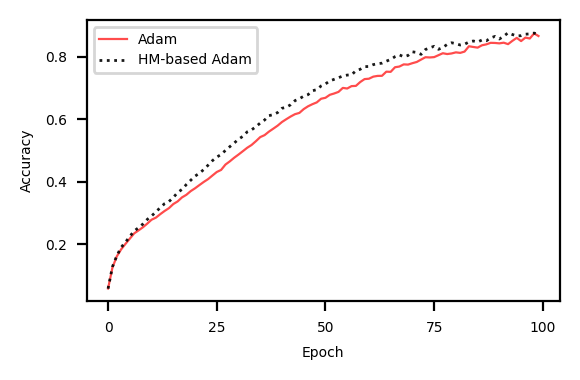

In [35]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['accuracy'] 
y2 = df2['accuracy']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Accuracy' , fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5}) 
#plt.title("Loss", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show() 

Accuracy

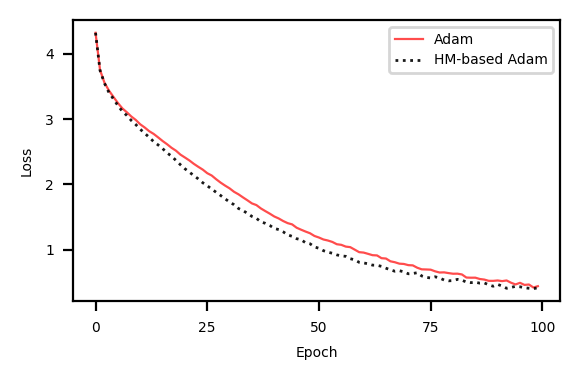

In [36]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['loss'] 
y2 = df2['loss']   
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Loss' , fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5}) 
#plt.title("Loss", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()  

###### Testing the model

Generic opimizer model

In [37]:
model_wihtout_hm.evaluate(X_test_normalized, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 9.3016 - accuracy: 0.2192


[9.30163860321045, 0.219200000166893]

HM based optimizer model

In [38]:
model_hm.evaluate(X_test_normalized, y_test)

313/313 [==============================] - 0s 761us/step - loss: 10.9936 - accuracy: 0.2129


[10.99357795715332, 0.21289999783039093]

#### Release the GPU memory